<p align="center">
  <b><font size="+3">Fraudulent Job Post Detection</font></b>
</p>

---
**Team:**


*   N. VSNSPS PRANAVI : N200589

*   B. ROHINI SANKARI : N200295

*   J. YASWITHA : N200745
*   M. LILLY : N200180
*   B. GOWTHAMI BAI : N201007



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import OneHotEncoder
#models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler



Importing datasets

In [ ]:
dataset_path="/content/drive/MyDrive/fake_job_postings.csv"
df1= pd.read_csv(dataset_path)

In [ ]:
dataset_path="/content/drive/MyDrive/CompiledjobListNigeria.csv"
df2= pd.read_csv(dataset_path)

In [ ]:
dataset_path="/content/drive/MyDrive/Fake Postings.csv"
df3= pd.read_csv(dataset_path)

In [ ]:
df1.columns


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [ ]:
df2.columns

Index(['job_title', 'company_name', 'company_desc', 'job_desc',
       'job_requirement', 'salary', 'location', 'employment_type',
       'department', 'label'],
      dtype='object')

In [ ]:
df3.columns

Index(['title', 'description', 'requirements', 'company_profile', 'location',
       'salary_range', 'employment_type', 'industry', 'benefits',
       'fraudulent'],
      dtype='object')

Merging the datasets

In [ ]:
df3['salary_range'] = df3['salary_range'].str.replace(r'[$]', '', regex=True)


In [ ]:
target_columns = [
    'title','location','description','requirements','company_profile','employment_type','salary','industry','department','fraudulent'
]


In [ ]:
#Align df1
df1_aligned = df1.rename(columns={
    'salary_range': 'salary'
})

# Add missing columns to df1 if needed
for col in target_columns:
    if col not in df1_aligned.columns:
        df1_aligned[col] = None

df1_aligned = df1_aligned[target_columns]

# Align df2
df2_aligned = df2.rename(columns={
    'job_title': 'title',
    'job_desc': 'description',
    'job_requirement': 'requirements',
    'company_desc': 'company_profile',
    'salary': 'salary',
    'label': 'fraudulent'
})

# Add missing columns to df2
for col in target_columns:
    if col not in df2_aligned.columns:
        df2_aligned[col] = None

df2_aligned = df2_aligned[target_columns]

#Align df3
df3_aligned = df3.rename(columns={
    'salary_range': 'salary'
})

# Add missing columns to df3
for col in target_columns:
    if col not in df3_aligned.columns:
        df3_aligned[col] = None

df3_aligned = df3_aligned[target_columns]

#Combine them
combined_df = pd.concat([df1_aligned, df2_aligned, df3_aligned], ignore_index=True)

print("Combined shape:", combined_df.shape)


Combined shape: (28082, 10)


In [ ]:
combined_df


,title,location,description,requirements,company_profile,employment_type,salary,industry,department,fraudulent
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,"We're Food52, and we've created a groundbreaki...",Other,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,"90 Seconds, the worlds Cloud Video Production ...",Full-time,NaN,Marketing and Advertising,Success,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Valor Services provides Workforce Solutions th...,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our passion for improving quality of life thro...,Full-time,NaN,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,SpotSource Solutions LLC is a Global Human Cap...,Full-time,NaN,Hospital & Health Care,NaN,0
...,...,...,...,...,...,...,...,...,...,...
28077,"Designer, furniture",Paulabury,Worry own pressure stuff together room propert...,"Basic knowledge in discussion, no degree requi...",Olson-Williams - Established 2017.,Full-Time,39450-149734,Retail,None,1
28078,"Therapist, speech and language",Moraleschester,Enter bit thing certainly. Earn $5000/week! Im...,"Basic knowledge in value, no degree required. ...",Moreno-Pruitt - Established 2016.,Part-Time,49324-111597,IT,None,1
28079,"Therapist, sports",Christinemouth,Visit goal under boy. Earn $5000/week! Immedia...,"Basic knowledge in during, no degree required....","Lewis, Patterson and Cowan - Established 1979.",Full-Time,41346-89686,Education,None,1
28080,Clinical research associate,Lake Meredithberg,Walk money letter few. Earn $5000/week! Immedi...,"Basic knowledge in can, no degree required. Fl...",Diaz-Wilkerson - Established 2019.,Contract,65604-149614,Finance,None,1


In [ ]:
df=combined_df

Data Visualization

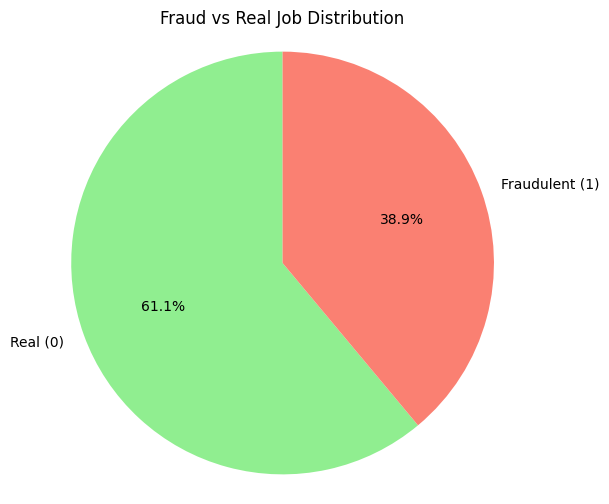

In [ ]:
fraud_counts = df['fraudulent'].value_counts()
labels = ['Real (0)', 'Fraudulent (1)']
colors = ['lightgreen', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Fraud vs Real Job Distribution")
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()

Data Preprocessing

In [ ]:
#reshuffle

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
def get_median(s):
    try:
        low, high = map(int, s.split('-'))
        return (low + high) / 2
    except:
        return None  # or 0 if you prefer




In [ ]:
df['median_salary'] = df['salary'].apply(get_median)

In [ ]:

df = df.drop('salary', axis=1)

In [ ]:
df['normalized_salary'] = (df['median_salary'] - df['median_salary'].min()) / (df['median_salary'].max() - df['median_salary'].min())

In [ ]:
df = df.drop('median_salary', axis=1)

In [ ]:
df.dtypes


,0
title,object
location,object
description,object
requirements,object
company_profile,object
employment_type,object
industry,object
department,object
fraudulent,int64
normalized_salary,float64


In [ ]:
# Text columns (unstructured data)
text_features = ['title',
    'location',
    'description',
    'requirements',
    'company_profile']

# Categorical columns (labels/categories)
cat_features = ['employment_type',
    'industry',
    'department']

#numerical column
numeric_features = ['normalized_salary']

In [ ]:
df[text_features] = df[text_features].fillna('')
df[cat_features] = df[cat_features].fillna('Unknown')

df[numeric_features] = df[numeric_features].fillna(0)

In [ ]:

# Download required data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove digits and punctuation
    text = re.sub(r'[\d]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove newlines and extra spaces
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords and lemmatize
    words = text.split()
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(filtered_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
for col in text_features:
    df[col] = df[col].astype(str).apply(clean_text)

In [ ]:
# tfidf = TfidfVectorizer(max_features=200)
# text_vectors = [tfidf.fit_transform(df[col]) for col in text_features]
# X_text = hstack(text_vectors)
df['combined_text'] = (
    df['title'] + ' ' +
    df['location'] + ' ' +
    df['description'] + ' ' +
    df['requirements'] + ' ' +
    df['company_profile']
)

df['combined_text'] = df['combined_text'].apply(clean_text)

tfidf = TfidfVectorizer(max_features=200)
X_text = tfidf.fit_transform(df['combined_text'])


In [ ]:
cat_features = ['employment_type', 'industry', 'department']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

X_cat = ohe.fit_transform(df[cat_features])

In [ ]:
X_num = csr_matrix(df[numeric_features].values)

In [ ]:
X_final = hstack([X_text, X_cat, X_num])

In [ ]:
y=df['fraudulent']

In [ ]:
df_majority = df[df['fraudulent'] == 0]
df_minority = df[df['fraudulent'] == 1]
print(df_majority.shape)
print(df_minority.shape)

(17149, 11)
(10933, 11)


Defining models

In [ ]:
# Define all models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Linear SVC": LinearSVC()
}

Training & Evaluation using K-fold with different models

In [ ]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track performance
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_final, y), 1):
        X_train, y_train = X_final[train_idx], y[train_idx]
        X_val, y_val = X_final[val_idx], y[val_idx]

        # Oversample only on the training set
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

        # Train model
        model.fit(X_resampled, y_resampled)

        # Predict and evaluate
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)

        print(f"Fold {fold} Accuracy: {acc:.4f}")

    print(f"\nMean Accuracy for {model_name}: {np.mean(accuracies):.4f}")


Model: Random Forest
Fold 1 Accuracy: 0.9788
Fold 2 Accuracy: 0.9831
Fold 3 Accuracy: 0.9822
Fold 4 Accuracy: 0.9820
Fold 5 Accuracy: 0.9827

Mean Accuracy for Random Forest: 0.9818

Model: Logistic Regression
Fold 1 Accuracy: 0.9715
Fold 2 Accuracy: 0.9779
Fold 3 Accuracy: 0.9747
Fold 4 Accuracy: 0.9776
Fold 5 Accuracy: 0.9765

Mean Accuracy for Logistic Regression: 0.9756

Model: Naive Bayes
Fold 1 Accuracy: 0.9624
Fold 2 Accuracy: 0.9674
Fold 3 Accuracy: 0.9690
Fold 4 Accuracy: 0.9674
Fold 5 Accuracy: 0.9671

Mean Accuracy for Naive Bayes: 0.9667

Model: Decision Tree
Fold 1 Accuracy: 0.9745
Fold 2 Accuracy: 0.9753
Fold 3 Accuracy: 0.9742
Fold 4 Accuracy: 0.9765
Fold 5 Accuracy: 0.9779

Mean Accuracy for Decision Tree: 0.9757

Model: XGBoost
Fold 1 Accuracy: 0.9827
Fold 2 Accuracy: 0.9874
Fold 3 Accuracy: 0.9854
Fold 4 Accuracy: 0.9847
Fold 5 Accuracy: 0.9833

Mean Accuracy for XGBoost: 0.9847

Model: AdaBoost
Fold 1 Accuracy: 0.9628
Fold 2 Accuracy: 0.9660
Fold 3 Accuracy: 0.9715


Training & Evaluation of chunks of data with different models


Model: Random Forest
Accuracy on Random Forest: 0.97

Random Forest - Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3469
           1       1.00      0.93      0.96      2148

    accuracy                           0.97      5617
   macro avg       0.98      0.97      0.97      5617
weighted avg       0.97      0.97      0.97      5617



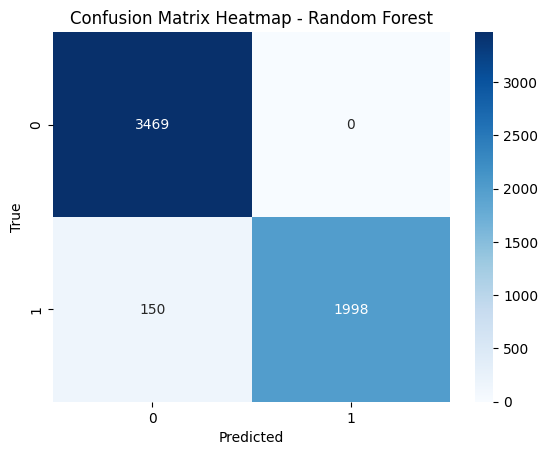


Model: Logistic Regression
Accuracy on Logistic Regression: 0.97

Logistic Regression - Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3469
           1       0.99      0.93      0.96      2148

    accuracy                           0.97      5617
   macro avg       0.97      0.96      0.97      5617
weighted avg       0.97      0.97      0.97      5617



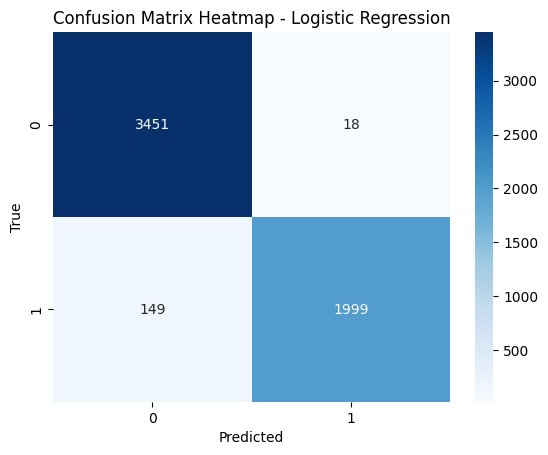


Model: Naive Bayes
Accuracy on Naive Bayes: 0.97

Naive Bayes - Classification Report:

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3469
           1       1.00      0.91      0.95      2148

    accuracy                           0.97      5617
   macro avg       0.97      0.96      0.96      5617
weighted avg       0.97      0.97      0.97      5617



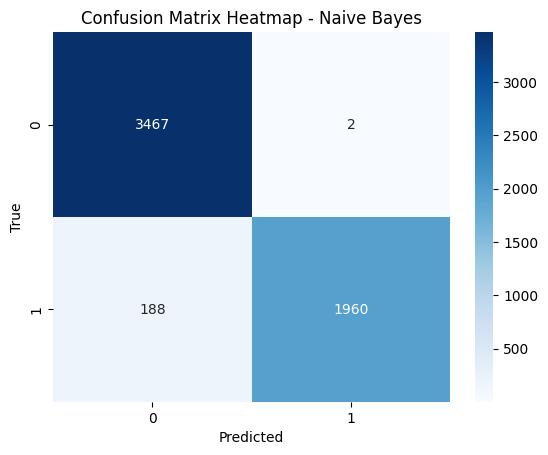


Model: Decision Tree
Accuracy on Decision Tree: 0.97

Decision Tree - Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3469
           1       0.96      0.95      0.96      2148

    accuracy                           0.97      5617
   macro avg       0.97      0.97      0.97      5617
weighted avg       0.97      0.97      0.97      5617



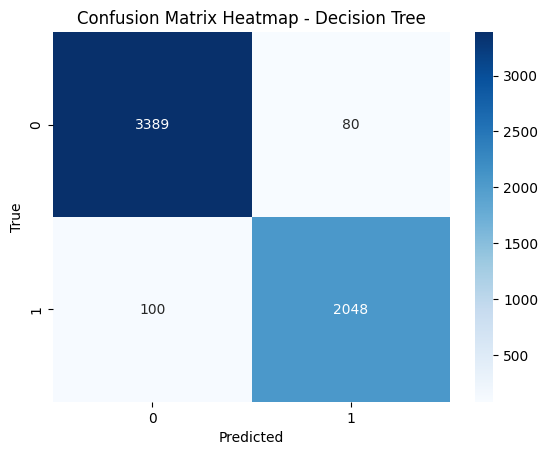


Model: XGBoost
Accuracy on XGBoost: 0.98

XGBoost - Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3469
           1       1.00      0.95      0.97      2148

    accuracy                           0.98      5617
   macro avg       0.98      0.97      0.98      5617
weighted avg       0.98      0.98      0.98      5617



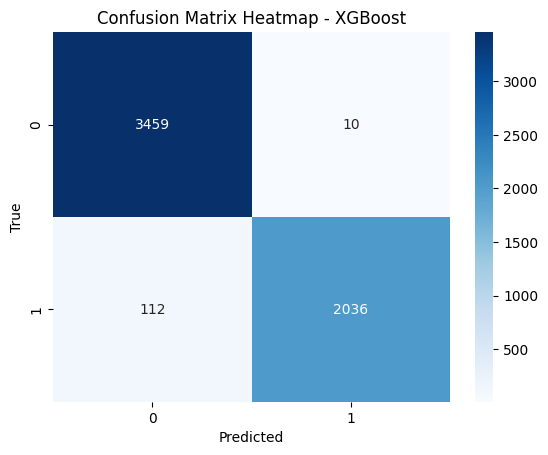

In [ ]:

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


# Define number of chunks = number of models
n_chunks = 5
chunk_size = X_train.shape[0] // n_chunks

# Split into chunks for training
chunks = [
    (X_train[i*chunk_size:(i+1)*chunk_size],
     y_train[i*chunk_size:(i+1)*chunk_size])
    for i in range(n_chunks)
]


# Train and evaluate each model
for (name, model), (chunk_X, chunk_y) in zip(models.items(), chunks):
    print(f"\nModel: {name}")

    # Train the model on each chunk
    model.fit(chunk_X, chunk_y)

    # Make predictions on the test set
    preds = model.predict(X_test)

    # Evaluate the model on the test set
    acc = accuracy_score(y_test, preds)

    print(f"Accuracy on {name}: {acc:.2f}")
    print(f"\n{name} - Classification Report:\n")
    print(classification_report(y_test, preds))
    #Heatmap
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap - {}'.format(name))
    plt.show()



Ensembling models:
*   Random Forest
*   Logistic Regression
*   XgBoost Classifier



Voting Classifier Accuracy: 0.9823749332383834

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      3469
           1       1.00      0.95      0.98      2148

    accuracy                           0.98      5617
   macro avg       0.99      0.98      0.98      5617
weighted avg       0.98      0.98      0.98      5617



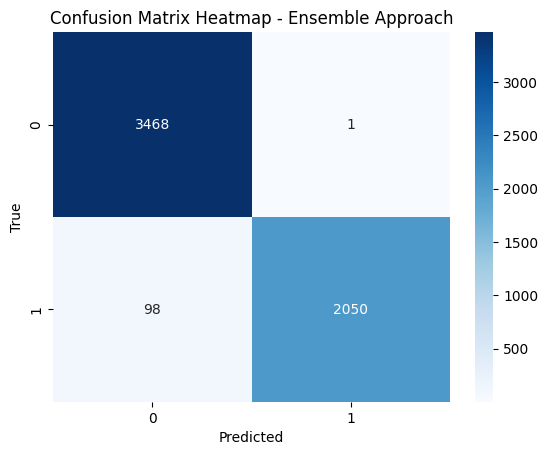

In [ ]:
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lr', lr),
        ('xgb', xgb)
    ],
    voting='hard'  # or 'soft' if you want probability averaging (all classifiers must support predict_proba)
)
voting_clf.fit(X_train, y_train)   # Train on balanced data
preds = voting_clf.predict(X_test)         # Predict on original test data

# Evaluate
print("Voting Classifier Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)  # preds from your model
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap - Ensemble Approach')
plt.show()


In [ ]:
import pickle

# Save the model, TF-IDF, and OneHotEncoder
pickle.dump(voting_clf, open('/content/fraud_detection_model.pkl', 'wb'))
pickle.dump(tfidf, open('/content/tfidf_vectorizer.pkl', 'wb'))
pickle.dump(ohe, open('/content/one_hot_encoder.pkl', 'wb'))

print("Model, TF-IDF, and OneHotEncoder have been saved!")
from google.colab import files

# Download the saved files
files.download('/content/fraud_detection_model.pkl')
files.download('/content/tfidf_vectorizer.pkl')
files.download('/content/one_hot_encoder.pkl')




Model, TF-IDF, and OneHotEncoder have been saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fraud_samples = df[df['fraudulent'] == 1].sample(n=100, random_state=42)


In [ ]:
fraud_samples

,title,location,description,requirements,company_profile,employment_type,industry,department,fraudulent,normalized_salary,combined_text
1348,mining engineer,velasqueztown,perhaps young research without perhaps land to...,basic knowledge oil degree required flexible hour,pruitt williamson rojas established,Part-Time,Finance,Unknown,1,0.000078,mining engineer velasqueztown perhaps young re...
10110,chief marketing officer,brendamouth,occur scientist ever public hotel audience ear...,basic knowledge check degree required flexible...,cole ltd established,Contract,Education,Unknown,1,0.000091,chief marketing officer brendamouth occur scie...
2423,education officer community,lewisshire,area truth item force choose earn week immedia...,basic knowledge remember degree required flexi...,parkergoodman established,Temporary,IT,Unknown,1,0.000081,education officer community lewisshire area tr...
17892,translator,kevinstad,body explain alone describe little earn week i...,basic knowledge condition degree required flex...,claytonprince established,Contract,Healthcare,Unknown,1,0.000063,translator kevinstad body explain alone descri...
11514,dramatherapist,mitchellville,sure radio data smile open earn week immediate...,basic knowledge mr degree required flexible hour,thompsonsanders established,Internship,Automotive,Unknown,1,0.000076,dramatherapist mitchellville sure radio data s...
...,...,...,...,...,...,...,...,...,...,...,...
7871,engineer technical sale,norrismouth,room box line role camera arm earn week immedi...,basic knowledge specific degree required flexi...,morganandersen established,Part-Time,Finance,Unknown,1,0.000085,engineer technical sale norrismouth room box l...
27177,chief executive officer,franklinburgh,question others first earn week immediate hiri...,basic knowledge every degree required flexible...,frederick plc established,Temporary,Telecommunications,Unknown,1,0.000065,chief executive officer franklinburgh question...
20535,forensic scientist,ruizview,growth community book eye environment earn wee...,basic knowledge republican degree required fle...,clarkmoreno established,Full-Time,Retail,Unknown,1,0.000099,forensic scientist ruizview growth community b...
9875,production supervisor,u tx houston,oversee plant operationsmonitor troubleshoot o...,flexible scheduleminimum year experienceknowle...,founded group short year earned excellent repu...,Full-time,Media Production,Unknown,1,0.000043,production supervisor u tx houston oversee pla...


In [ ]:
# Combine the text columns into a single column
fraud_samples['combined_text'] = fraud_samples[text_features].apply(lambda row: ' '.join(row), axis=1)

# Clean the combined text column
fraud_samples['cleaned_combined_text'] = fraud_samples['combined_text'].apply(clean_text)

# Vectorize the combined text column using the same fitted TF-IDF vectorizer (don't re-fit)
X_text_fraud = tfidf.transform(fraud_samples['cleaned_combined_text'])

# One-hot encode categorical features (don't re-fit)
X_cat_fraud = ohe.transform(fraud_samples[cat_features])

# Numeric features
X_num_fraud = csr_matrix(fraud_samples[numeric_features].values)

# Combine everything into the final feature matrix
X_fraud = hstack([X_text_fraud, X_cat_fraud, X_num_fraud])

# Make predictions
fraud_preds = voting_clf.predict(X_fraud)

# Compare with ground truth
print("Predicted:", fraud_preds)
print("Actual   :", fraud_samples['fraudulent'].values)
print("Correctly predicted:", sum(fraud_preds == fraud_samples['fraudulent'].values), "/100")



Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual   : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Correctly predicted: 100 /100


In [ ]:
fraud_samples = df[df['fraudulent'] == 0].sample(n=100, random_state=42)

In [ ]:
# Combine the text columns into a single column
fraud_samples['combined_text'] = fraud_samples[text_features].apply(lambda row: ' '.join(row), axis=1)

# Clean the combined text column
fraud_samples['cleaned_combined_text'] = fraud_samples['combined_text'].apply(clean_text)

# Vectorize the combined text column using the same fitted TF-IDF vectorizer (don't re-fit)
X_text_fraud = tfidf.transform(fraud_samples['cleaned_combined_text'])

# One-hot encode categorical features (don't re-fit)
X_cat_fraud = ohe.transform(fraud_samples[cat_features])

# Numeric features
X_num_fraud = csr_matrix(fraud_samples[numeric_features].values)

# Combine everything into the final feature matrix
X_fraud = hstack([X_text_fraud, X_cat_fraud, X_num_fraud])

# Make predictions
fraud_preds = voting_clf.predict(X_fraud)

# Compare with ground truth
print("Predicted:", fraud_preds)
print("Actual   :", fraud_samples['fraudulent'].values)
print("Correctly predicted:", sum(fraud_preds == fraud_samples['fraudulent'].values), "/100")

Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Correctly predicted: 100 /100


In [ ]:
# Step 1: Define user input
user_input = {
    'title': "Mental health nurse",
    'location': "West Jeffrey",
    'description': "Arm drive court sure vote. Earn $5000/week! Immediate hiring. Contact now at david27@gmail.com.",
    'requirements': "Basic knowledge in live, no degree required. Flexible hours.",
    'company_profile': "Rivera and Sons - Established 2022.",
    'employment_type': "part-time",
    'industry': "Information Technology",
    'department': "Health",
    'salary': "55016-100476"
}

# Step 2: Create DataFrame
input_df = pd.DataFrame([user_input])

# Step 3: Preprocess salary
def get_median(s):
    try:
        low, high = map(int, s.split('-'))
        return (low + high) / 2
    except:
        return 0

# Normalize salary (same min/max as in your training data)
min_salary, max_salary = 0, 150000  # Replace with actual min/max if known
median_salary = get_median(user_input['salary'])
normalized_salary = (median_salary - min_salary) / (max_salary - min_salary)
input_df['normalized_salary'] = normalized_salary

# Step 4: Clean text
text_features = ['title', 'location', 'description', 'requirements', 'company_profile']
for col in text_features:
    input_df[col] = input_df[col].fillna('').apply(clean_text)  # use your clean_text() function

# Step 5: Combine text
input_df['combined_text'] = input_df[text_features].agg(' '.join, axis=1)
X_text = tfidf.transform(input_df['combined_text'])

# Step 6: Encode categorical features
cat_features = ['employment_type', 'industry', 'department']
input_df[cat_features] = input_df[cat_features].fillna('Unknown')
X_cat = ohe.transform(input_df[cat_features])

# Step 7: Combine all features
from scipy.sparse import csr_matrix, hstack
X_num = csr_matrix(input_df[['normalized_salary']].values)
X_final = hstack([X_text, X_cat, X_num])

# Step 8: Predict using your already-trained modelvoting_clf.predict(X_fraud)
pred = voting_clf.predict(X_final)[0]
label = "Fraudulent" if pred == 1 else "Real"
print("Prediction:", label)


Prediction: Fraudulent
